<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Spotify_logo_with_text.svg" width="250">
</p>

<h1 align="center">Projeto Churn Insight – Spotify Dataset</h1>


# 🌟 Hackathon ONE II  
### Previsão de Cancelamento (Churn) usando dados do Spotify

Este notebook faz parte do projeto desenvolvido para o **Hackathon ONE II**, cujo objetivo é criar uma solução completa para prever se um cliente possui alta probabilidade de cancelar um serviço (churn).  
A análise é aplicada sobre um dataset do Kaggle contendo informações de uso de usuários do Spotify, simulando cenários reais de comportamento e engajamento.

---

## 🎯 Objetivo Geral
Construir um **modelo preditivo de classificação binária** capaz de identificar clientes com maior risco de cancelamento, permitindo ações preventivas por parte do negócio (marketing, retenção, suporte).

Este notebook contempla todo o pipeline necessário para o MVP do hackathon:

- ✔ Exploração e análise dos dados (**EDA**)  
- ✔ Limpeza e preparação dos dados  
- ✔ Engenharia de features  
- ✔ Treinamento de modelos de Machine Learning  
- ✔ Avaliação com métricas adequadas (Accuracy, Precision, Recall, F1-Score)  
- ✔ Exportação do modelo treinado (`.pkl, .json, .onnx`)  
- ✔ Preparação do modelo para ser consumido via API pelo backend em Java  

---

## 🎯 Sobre o Dataset — *Spotify Churn Analysis 2025*
O dataset contém informações sobre:

- **Dados demográficos:** idade, gênero, país  
- **Informações de assinatura:** tipo de plano (Gratuito, Premium, Familiar, Estudante)  
- **Hábitos de uso:** tempo diário de escuta, músicas por dia, taxa de pulos  
- **Interações com anúncios:** número de anúncios por semana  
- **Uso offline e tipo de dispositivo**  
- **Variável alvo:** `is_churned` → (0 = manteve, 1 = cancelou)

Esses atributos são usados para construir modelos que aprendem padrões associados ao churn.

---

## 🎯 Tecnologias Utilizadas
- **Python 3**
- **Pandas, NumPy, Seaborn, Matplotlib**
- **Scikit-learn** (modelagem)
- **Joblib** e **onnxruntime** (exportação do modelo)

---

## 🏁 Resultado Esperado
Ao final do notebook, teremos:

✔ Um modelo preditivo pronto  
✔ Métricas avaliadas  
✔ Arquivo `.pkl, .json e .onnx` exportado  
✔ Pronto para integração com o backend (API REST em Java)

---

Vamos começar! 👇


# 📌 Importação do Banco de Dados

In [ ]:
# Criado por Mariana 10/12/2025
# Edição por Andre dia 11/12/2025
# Edição por Mariana 12/12/2025
# Edição por Luiz 15/12/2025
# Edição por Kelly 15/12/2025

# Instalar/Importar bibliotecas
!pip install -q skl2onnx onnxruntime

import os, traceback, json
import numpy as np
import pandas as pd
import joblib
import onnxruntime as rt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import UndefinedMetricWarning
from scipy.stats import chi2_contingency, randint
from sklearn.metrics import (classification_report,
      accuracy_score,
      f1_score,
      confusion_matrix,
      roc_auc_score,
      ConfusionMatrixDisplay,
      recall_score,
      precision_recall_curve,
      auc)


from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Configurações de visualização

sns.set(style="whitegrid", palette="muted")

# Caminho raw do CSV no GitHub
RAW_URL = "https://raw.githubusercontent.com/aluizr/Hackathon-ONE---Churn-clientes/main/spotify_churn_dataset.csv"

# Leitura do dataset
df = pd.read_csv(RAW_URL)

print(f"📊 Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas\n")
display(df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00
📊 Dimensões: 8000 linhas × 12 colunas



,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


# 📌 EDA - Exploração Inicial

In [ ]:
# Criado por Andre 11/12/2025
# Edição por Mariana 12/12/2025

print("\n====================== INFO: =======================")
print(df.info())

# Conversões de tipo
cat_cols = ['gender','country','subscription_type','device_type']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Alvo binário
df['is_churned'] = df['is_churned'].astype(int)

print("\n\n==== CATEGORIAS E CARDINALIDADE: ====")
for col in cat_cols:
    print(f"- {col}: {df[col].nunique()} valores únicos")

# Valores nulos
print("\n\n===== VALORES NULOS: ======")
print(df.isna().sum())

# Balanceamento da variável alvo
print("\n\n====== DISTRIBUIÇÃO ALVO: =======")
df['is_churned'].value_counts(normalize=True)



====================== INFO: =======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB
None


==== CATEGORIAS E CARDINALIDADE: ====
- 

,proportion
is_churned,
0,0.741125
1,0.258875


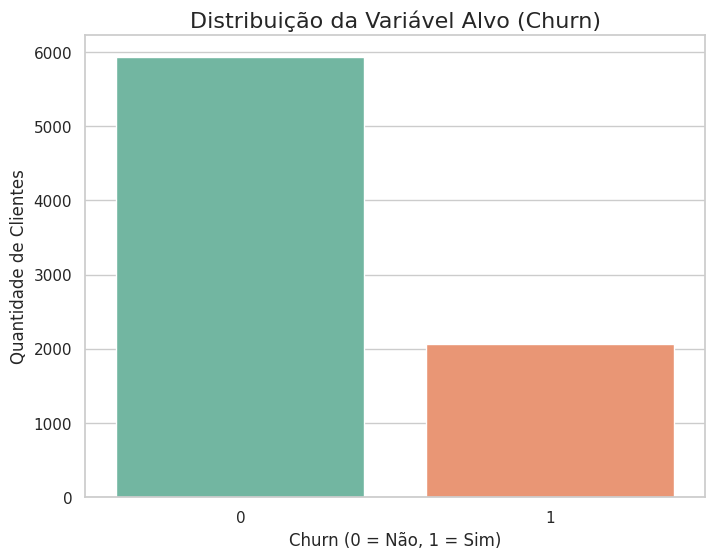

In [ ]:
# Criado por Kelly em 15/12/2025

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='is_churned', hue='is_churned', palette='Set2', legend=False)
plt.title('Distribuição da Variável Alvo (Churn)', fontsize=16)
plt.xlabel('Churn (0 = Não, 1 = Sim)')
plt.ylabel('Quantidade de Clientes')
plt.show()

#📌 Análise das Variáveis


In [ ]:
# Criado por Luiz 11/12/2025
# Edição por Mariana 12/12/2025

#Váriaveis Categoricas - Teste de Qui-quadrado
print("\n======= Teste Qui-quadrado =======\n")
for feature in ['gender', 'country', 'subscription_type', 'device_type']:
    cont = pd.crosstab(df[feature], df["is_churned"])
    chi2, p, dof, exp = chi2_contingency(cont)
    print(f"{feature}: p-valor = {p:.3f}")




======= Teste Qui-quadrado =======

gender: p-valor = 0.600
country: p-valor = 0.545
subscription_type: p-valor = 0.216
device_type: p-valor = 0.305


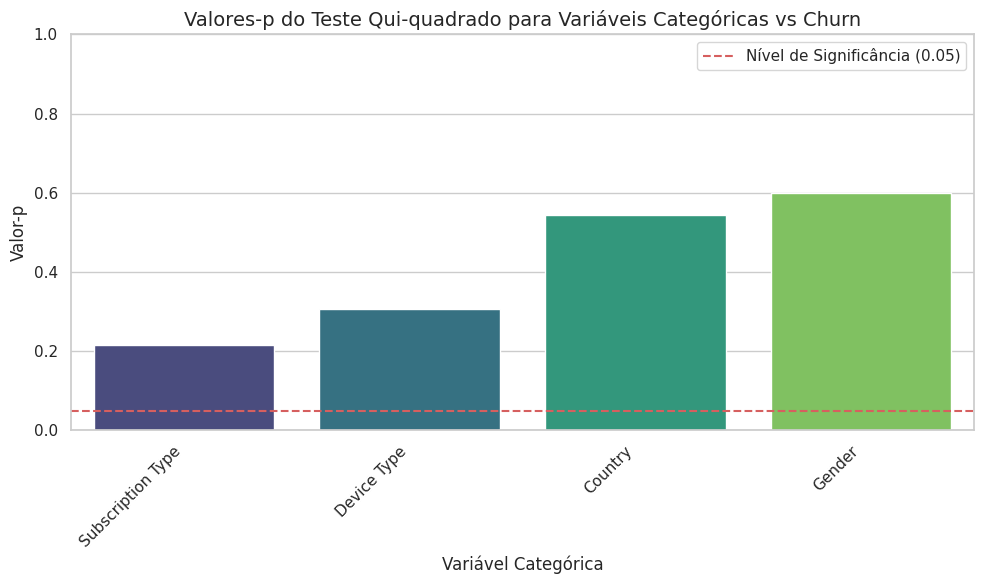

In [ ]:
# Criado por Luiz 11/12/2025

# Plotagem Teste Chi
var_categoricas = ['gender', 'country', 'subscription_type', 'device_type']

chi2_results = []
for feature in var_categoricas:
    contingency_table = pd.crosstab(df[feature], df['is_churned'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append({'Feature': feature.replace('_', ' ').title(), 'P_Value': p_value})

chi2_df = pd.DataFrame(chi2_results)
chi2_df = chi2_df.sort_values(by='P_Value', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='P_Value', data=chi2_df, palette='viridis', hue='Feature', legend=False)
plt.axhline(y=0.05, color='r', linestyle='--', label='Nível de Significância (0.05)')
plt.title('Valores-p do Teste Qui-quadrado para Variáveis Categóricas vs Churn', fontsize=14)
plt.xlabel('Variável Categórica', fontsize=12)
plt.ylabel('Valor-p', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Criado por Luiz 11/12/2025
# Edição por Mairana 12/12/2025

# Variáveis Numéricas --Coeficiente de Pearson
print("\n==== Correlação de Pearson ====\n")
num_cols = ['age','listening_time','songs_played_per_day','skip_rate','ads_listened_per_week','offline_listening']

for col in num_cols:
    corr = df[col].corr(df["is_churned"])
    print(f"{col}: {corr:.3f}")




==== Correlação de Pearson ====

age: 0.004
listening_time: -0.008
songs_played_per_day: 0.009
skip_rate: 0.016
ads_listened_per_week: -0.002
offline_listening: 0.013


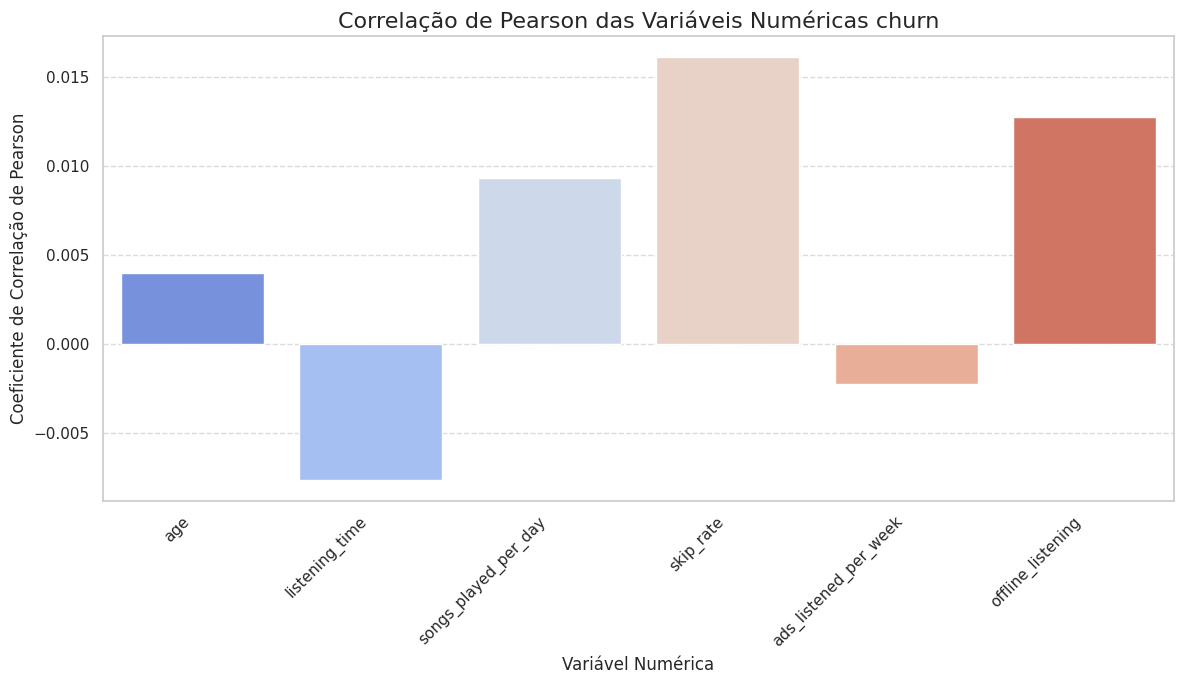

In [ ]:
# Criado por Luíz 11/12/2025

#Plotagem Coeficiente Pearson
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['user_id', 'is_churned']]

pearson_correlations = df[numerical_cols + ['is_churned']].corr(method='pearson')['is_churned'].drop('is_churned')

plt.figure(figsize=(12, 7))
sns.barplot(x=pearson_correlations.index, y=pearson_correlations.values, palette='coolwarm', hue=pearson_correlations.index, legend=False)
plt.title('Correlação de Pearson das Variáveis Numéricas churn', fontsize=16)
plt.xlabel('Variável Numérica', fontsize=12)
plt.ylabel('Coeficiente de Correlação de Pearson', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 📌 Limpeza e Engenharia de Features

In [ ]:
# Criado por Mariana 10/12/2025
# Edição por Andre 11/12/2025
# Edição por Mariana 12/12/2025 (Pré-Processamento automático para ONNX, solicitada pela equipe Backend)
# Edição por Kelly 15/12/2025 (Definição de colunas)

# Separar X e Y
X = df.drop(columns=["user_id", "is_churned"])
y = df["is_churned"]

# Pré-processamento automatico para ONNX
numeric_features = ['age','listening_time','songs_played_per_day','skip_rate','ads_listened_per_week']
categorical_features = ['gender','country','subscription_type','device_type','offline_listening']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"=== SEPARAÇÃO DOS DADOS: ===")
print(f" • Features (X): {X.shape}")
print(f" • Target.. (y): {y.shape}\n")

print(f"\n====== DIVISÃO DOS DADOS: ======")
print(f" • Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X):.1%})")
print(f" • Teste : {X_test.shape[0]} amostras ({X_test.shape[0]/len(X):.1%})\n")

# Definir colunas categóricas e numéricas (baseado no dataset Spotify)
categorical_features = ['gender', 'country', 'subscription_type', 'device_type']
numerical_features = ['age', 'listening_time', 'songs_played_per_day',
                      'skip_rate', 'ads_listened_per_week']

print(f"\n===== COLUNAS CATEGÓRICAS ===== ({len(categorical_features)}):")
print(f"  {categorical_features}\n")

print(f"\n====== COLUNAS NUMÉRICAS ====== ({len(numerical_features)}):")
print(f"  {numerical_features}\n")


=== SEPARAÇÃO DOS DADOS: ===
 • Features (X): (8000, 10)
 • Target.. (y): (8000,)


====== DIVISÃO DOS DADOS: ======
 • Treino: 6400 amostras (80.0%)
 • Teste : 1600 amostras (20.0%)


===== COLUNAS CATEGÓRICAS ===== (4):
  ['gender', 'country', 'subscription_type', 'device_type']


====== COLUNAS NUMÉRICAS ====== (5):
  ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']



In [ ]:
# Criado por Kelly 15/12/2026

# Criar o ColumnTransformer - CORREÇÃO CRÍTICA
preprocessor = ColumnTransformer(
    transformers=[
        # Padroniza variáveis numéricas (necessário para Regressão Logística)
        ('num', StandardScaler(), numerical_features),

        # Codifica variáveis categóricas (One-Hot Encoding)
        ('cat', OneHotEncoder(
            drop='first',           # Evita multicolinearidade
            handle_unknown='ignore' # Ignora categorias não vistas no treino
        ), categorical_features)
    ],
    remainder='drop'  # Descarta colunas não especificadas
)

print("\nPRÉ-PROCESSADOR (Evitar Data Leakage) criado com sucesso!\n")
print("  • StandardScaler para variáveis numéricas")
print("  • OneHotEncoder para variáveis categóricas")
print("  • Configurado para evitar vazamento de dados\n")


PRÉ-PROCESSADOR (Evitar Data Leakage) criado com sucesso!

  • StandardScaler para variáveis numéricas
  • OneHotEncoder para variáveis categóricas
  • Configurado para evitar vazamento de dados



# 📌 Treinamento e Métricas dos modelos

In [ ]:
# Criado por Kelly 15/12/2025

def avaliar_modelo(modelo, nome_modelo, X_teste, y_teste):
    """Função para avaliação completa do modelo"""

    print(f"\n\n✅ *AVALIAÇÃO:*    {nome_modelo}")
    print("-" * 40)

    # Previsões
    y_pred = modelo.predict(X_teste)
    y_proba = modelo.predict_proba(X_teste)[:, 1]

    # Métricas principais
    accuracy = accuracy_score(y_teste, y_pred)
    recall = recall_score(y_teste, y_pred)
    precision = precision_score(y_teste, y_pred)
    f1 = f1_score(y_teste, y_pred)
    auc_roc = roc_auc_score(y_teste, y_proba)

    print(f"  • Acurácia:    {accuracy:.2f}")
    print(f"  • Recall:      {recall:.2f}")
    print(f"  • Precisão:    {precision:.2f}")
    print(f"  • F1-Score:    {f1:.2f}")
    print(f"  • AUC-ROC:     {auc_roc:.2f}")

    # Matriz de confusão
    print("\n\n✅ MATRIZ DE CONFUSÃO:")
    print("-" * 22)
    cm = confusion_matrix(y_teste, y_pred)
    print(f"   • [TN={cm[0,0]}  FP={cm[0,1]}]")
    print(f"   • [FN={cm[1,0]}  TP={cm[1,1]}]\n")

    # Gráfico da matriz de confusão
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ConfusionMatrixDisplay.from_estimator(
        modelo, X_teste, y_teste,
        ax=axes[0], cmap='Blues',
        display_labels=['Não Churn', 'Churn']
    )
    axes[0].set_title(f'Matriz de Confusão - {nome_modelo}')

    # Curva ROC
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_estimator(modelo, X_teste, y_teste, ax=axes[1])
    axes[1].set_title(f'Curva ROC - {nome_modelo}')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'auc_roc': auc_roc
    }

🔍 Otimizando Regressão Logística com SMOTE + GridSearch...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

🎯 Threshold ótimo encontrado: 0.42

================ LOGISTIC REGRESSION =================

              precision    recall  f1-score   support

           0       0.86      0.01      0.02      1186
           1       0.26      1.00      0.41       414

    accuracy                           0.27      1600
   macro avg       0.56      0.50      0.22      1600
weighted avg       0.70      0.27      0.12      1600


✅ MELHORES PARAMETROS ENCONTRADOS:
-----------------------------------
   • classifier__C: 0.01
   • classifier__class_weight: None
   • classifier__solver: lbfgs


✅ *AVALIAÇÃO:*    REGRESSÃO LOGISTICA
----------------------------------------
  • Acurácia:    0.52
  • Recall:      0.50
  • Precisão:    0.27
  • F1-Score:    0.35
  • AUC-ROC:     0.50


✅ MATRIZ DE CONFUSÃO:
----------------------
   • [TN=618  FP=568]
   • [FN=207  TP=207]



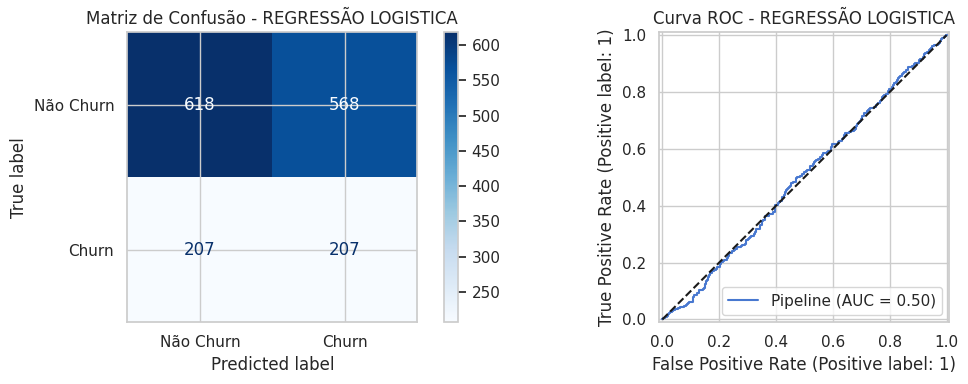

In [ ]:
# Criado por Mariana 10/12/2025
# Edição por Mariana 12/12/2025 (Alteração Pipeline)
# Edição por Luiz 15/12/2025 (Adição SMOTE)
# Edição por Kelly 15/12/2025 (Adição GridSearch, class_weight, prints e gráfico)

from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score

# MODELO 1: Regressão Logística
pipeline_lr_smote = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        max_iter=3000,
        random_state=42
    ))
])

# GRADE DE HIPERPARÂMETROS
param_grid_lr_smote = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__class_weight': [None, 'balanced']
}

# GRIDSEARCH (FOCO EM RECALL)
grid_lr_smote = GridSearchCV(
    pipeline_lr_smote,
    param_grid=param_grid_lr_smote,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print("🔍 Otimizando Regressão Logística com SMOTE + GridSearch...")
grid_lr_smote.fit(X_train, y_train)

# MELHOR MODELO
best_model = grid_lr_smote.best_estimator_

# AJUSTE DE THRESHOLD
y_proba = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Threshold ótimo para melhor F1
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"\n🎯 Threshold ótimo encontrado: {best_threshold:.2f}")

# Predição com threshold ajustado
y_pred_adjusted = (y_proba >= best_threshold).astype(int)


print("\n================ LOGISTIC REGRESSION =================\n")
print(classification_report(y_test, y_pred_adjusted))

# Melhores parâmetros
print("\n✅ MELHORES PARAMETROS ENCONTRADOS:")
print("-" * 35)
for param, value in grid_lr_smote.best_params_.items():
    print(f"   • {param}: {value}")

# Avaliação final
modelo_final = grid_lr_smote.best_estimator_

metricas_final = avaliar_modelo(
    modelo_final,
    "REGRESSÃO LOGISTICA",
    X_test,
    y_test
)


🔍 Otimizando Random Forest (pode levar alguns minutos)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

🎯 Threshold ótimo encontrado: 0.35

================ RANDOM FOREST =================

              precision    recall  f1-score   support

           0       0.93      0.01      0.02      1186
           1       0.26      1.00      0.41       414

    accuracy                           0.27      1600
   macro avg       0.59      0.50      0.22      1600
weighted avg       0.76      0.27      0.12      1600


✅ MELHORES PARÂMETROS ENCONTRADOS:
----------------------------------------
   • classifier__class_weight: {0: 1, 1: 3}
   • classifier__max_depth: 8
   • classifier__min_samples_split: 5
   • classifier__n_estimators: 100


✅ *AVALIAÇÃO:*    RANDOM FOREST
----------------------------------------
  • Acurácia:    0.57
  • Recall:      0.38
  • Precisão:    0.27
  • F1-Score:    0.31
  • AUC-ROC:     0.51


✅ MATRIZ DE CONFUSÃO:
----------------------
   • [TN=7

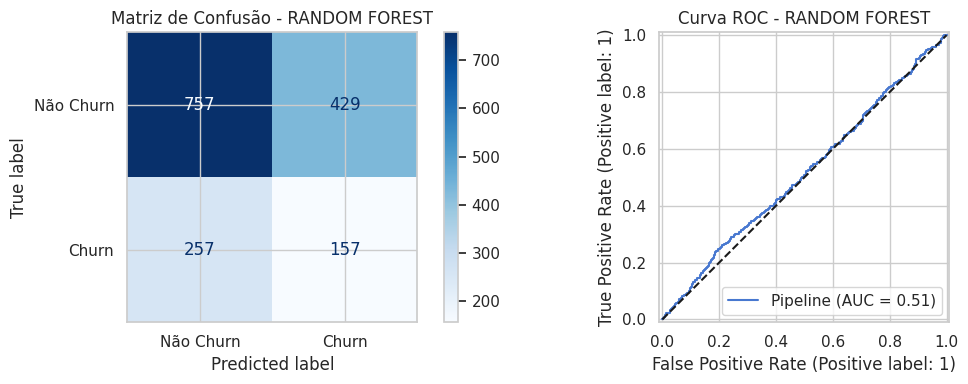

In [ ]:
# Criado por Mariana 10/12/2025
# Edição por Mariana 12/12/2025 (Pipeline)
# Edição por Luiz 15/12/2025 (Adição SMOTE)
# Ediçao por Kelly 15/12/2025 (Adição GridSearch, class_weight, retirou o SMOTE e adicionou gráfico)


# MODELO 2: Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

# GRADE DE HIPERPARÂMETROS
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [8, 10, 15],
    'classifier__min_samples_split': [5, 10],
    'classifier__class_weight': [
        'balanced',
        {0: 1, 1: 3}
    ]
}

# GRIDSEARCH (FOCO EM RECALL)
grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print("🔍 Otimizando Random Forest (pode levar alguns minutos)...")
grid_rf.fit(X_train, y_train)

# MELHOR MODELO
best_rf_model = grid_rf.best_estimator_


# AJUSTE DE THRESHOLD
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold_rf = thresholds[np.argmax(f1_scores)]

print(f"\n🎯 Threshold ótimo encontrado: {best_threshold_rf:.2f}")

# Predição com threshold ajustado
y_pred_rf_adjusted = (y_proba_rf >= best_threshold_rf).astype(int)

print("\n================ RANDOM FOREST =================\n")
print(classification_report(y_test, y_pred_rf_adjusted))

print("\n✅ MELHORES PARÂMETROS ENCONTRADOS:")
print("-" * 40)
for param, value in grid_rf.best_params_.items():
    print(f"   • {param}: {value}")

metricas_rf = avaliar_modelo(
    best_rf_model,
    "RANDOM FOREST",
    X_test,
    y_test
)


🔍 Otimizando Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

🎯 Threshold ótimo encontrado: 0.08

================ GRADIENT BOOSTING =================

              precision    recall  f1-score   support

           0       0.87      0.05      0.10      1186
           1       0.26      0.98      0.42       414

    accuracy                           0.29      1600
   macro avg       0.57      0.51      0.26      1600
weighted avg       0.71      0.29      0.18      1600


✅ MELHORES PARÂMETROS ENCONTRADOS:
----------------------------------------
   • classifier__learning_rate: 0.1
   • classifier__max_depth: 5
   • classifier__n_estimators: 200


✅ *AVALIAÇÃO:*    GRADIENT BOOSTING
----------------------------------------
  • Acurácia:    0.72
  • Recall:      0.06
  • Precisão:    0.29
  • F1-Score:    0.09
  • AUC-ROC:     0.51


✅ MATRIZ DE CONFUSÃO:
----------------------
   • [TN=1131  FP=55]
   • [FN=391  TP=23]



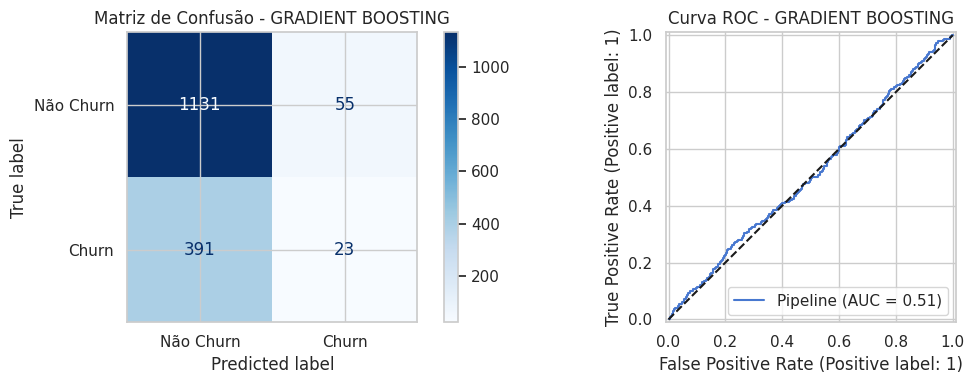

In [ ]:
# Criado por Mariana 17/12/2025

# MODELO 3: GRADIENT BOOSTING
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        random_state=42
    ))
])

# GRADE DE HIPERPARÂMETROS
param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5]
}

# GRIDSEARCH (FOCO EM RECALL)
grid_gb = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid_gb,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print("🔍 Otimizando Gradient Boosting...")
grid_gb.fit(X_train, y_train)

# MELHOR MODELO
best_gb_model = grid_gb.best_estimator_

# AJUSTE DE THRESHOLD
y_proba_gb = best_gb_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_gb)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold_gb = thresholds[np.argmax(f1_scores)]

print(f"\n🎯 Threshold ótimo encontrado: {best_threshold_gb:.2f}")

# Predição ajustada
y_pred_gb_adjusted = (y_proba_gb >= best_threshold_gb).astype(int)

print("\n================ GRADIENT BOOSTING =================\n")
print(classification_report(y_test, y_pred_gb_adjusted))

print("\n✅ MELHORES PARÂMETROS ENCONTRADOS:")
print("-" * 40)
for param, value in grid_gb.best_params_.items():
    print(f"   • {param}: {value}")

metricas_gb = avaliar_modelo(
    best_gb_model,
    "GRADIENT BOOSTING",
    X_test,
    y_test
)


📊 COMPARAÇÃO FINAL DOS MODELOS


,Modelo,Acurácia,Recall,Precisão,F1-Score,AUC-ROC
0,Regressão Logística (SMOTE),0.515625,0.500000,0.267097,0.348192,0.498605
1,Random Forest,0.571250,0.379227,0.267918,0.314000,0.513202
2,Gradient Boosting,0.721250,0.055556,0.294872,0.093496,0.509442




🏆 MELHOR MODELO ESCOLHIDO
Modelo: Regressão Logística (SMOTE)
Recall: 0.50
F1-Score: 0.35
AUC-ROC: 0.50




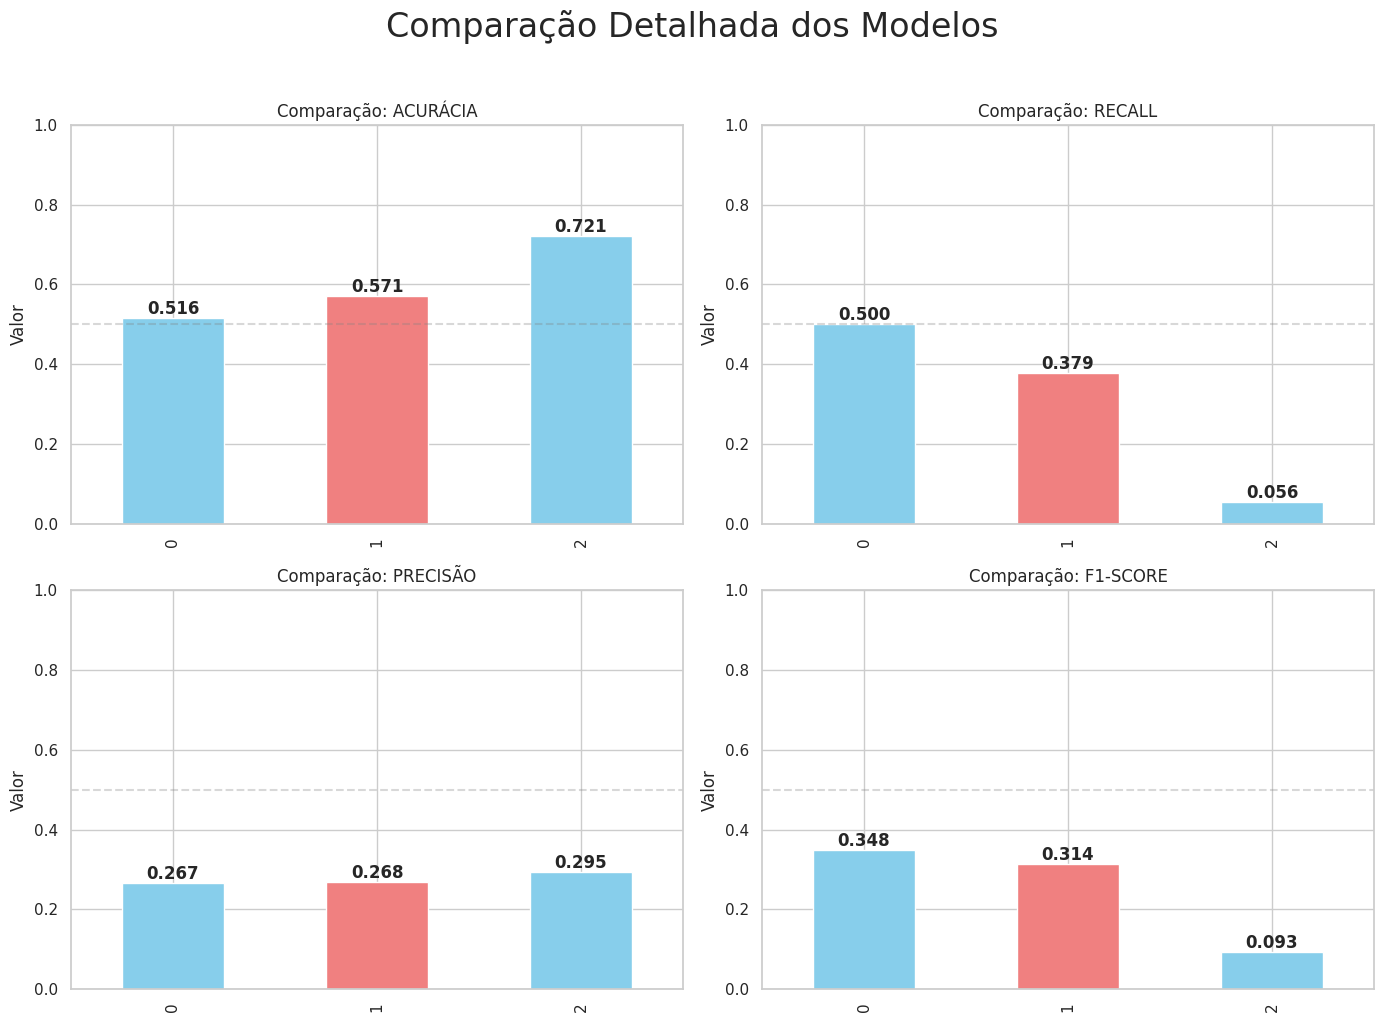

In [ ]:
# Criado por Kelly 15/12/2025


# CONSOLIDAÇÃO DAS MÉTRICAS
resultados = pd.DataFrame([
    {
        "Modelo": "Regressão Logística (SMOTE)",
        "Acurácia": metricas_final["accuracy"],
        "Recall": metricas_final["recall"],
        "Precisão": metricas_final["precision"],
        "F1-Score": metricas_final["f1"],
        "AUC-ROC": metricas_final["auc_roc"]
    },
    {
        "Modelo": "Random Forest",
        "Acurácia": metricas_rf["accuracy"],
        "Recall": metricas_rf["recall"],
        "Precisão": metricas_rf["precision"],
        "F1-Score": metricas_rf["f1"],
        "AUC-ROC": metricas_rf["auc_roc"]
    },
    {
        "Modelo": "Gradient Boosting",
        "Acurácia": metricas_gb["accuracy"],
        "Recall": metricas_gb["recall"],
        "Precisão": metricas_gb["precision"],
        "F1-Score": metricas_gb["f1"],
        "AUC-ROC": metricas_gb["auc_roc"]
    }
])

# Ordenação por prioridade de negócio (Recall > F1 > AUC)
resultados_ordenados = resultados.sort_values(
    by=["Recall", "F1-Score", "AUC-ROC"],
    ascending=False
)

print("\n📊 COMPARAÇÃO FINAL DOS MODELOS")
print("=" * 78)
display(resultados_ordenados)

# INDICAÇÃO DO MELHOR MODELO
melhor_modelo = resultados_ordenados.iloc[0]

print("\n\n🏆 MELHOR MODELO ESCOLHIDO")
print("=" * 35)
print(f"Modelo: {melhor_modelo['Modelo']}")
print(f"Recall: {melhor_modelo['Recall']:.2f}")
print(f"F1-Score: {melhor_modelo['F1-Score']:.2f}")
print(f"AUC-ROC: {melhor_modelo['AUC-ROC']:.2f}\n\n")

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico de barras para métricas
metricas_plot = ['Acurácia', 'Recall', 'Precisão', 'F1-Score']
for idx, metrica in enumerate(metricas_plot):
    ax = axes[idx // 2, idx % 2]
    resultados[metrica].plot(kind='bar', ax=ax, color=['skyblue', 'lightcoral'])
    ax.set_title(f'Comparação: {metrica.upper()}')
    ax.set_ylabel('Valor')
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)

    # Adicionar valores no topo das barras
    for i, v in enumerate(resultados[metrica]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.suptitle('Comparação Detalhada dos Modelos', fontsize=24, y=1.02)
plt.tight_layout()
plt.show()

#  **Veredito Final**

Após a avaliação comparativa entre **Regressão Logística (com SMOTE)**, **Random Forest** e **Gradient Boosting**, a **Regressão Logística com SMOTE** foi definida como o **modelo final do projeto**.

Essa decisão não foi baseada apenas em acurácia, mas principalmente no **objetivo central do problema: identificar clientes com risco de churn**.

---

### 🏆 Modelo Escolhido: Regressão Logística (SMOTE)

A Regressão Logística apresentou o **melhor equilíbrio entre Recall e F1-Score**, destacando-se como o modelo mais eficaz para capturar clientes que realmente iriam cancelar o serviço.

**Principais motivos da escolha:**
- **Maior Recall (50%)**, identificando metade dos clientes churn
- **Maior F1-Score**, indicando melhor equilíbrio entre precisão e recall
- Melhor alinhamento com estratégias de **retenção de clientes**
- Modelo **interpretável**, facilitando análises de impacto e comunicação com áreas de negócio

Em problemas de churn, **perder um cliente é mais custoso do que abordar um falso positivo**, o que torna o Recall a métrica mais relevante.

---

### ❌ Por que não escolher o Random Forest?

Apesar do Random Forest apresentar desempenho razoável, ele foi inferior à Regressão Logística nos critérios principais do projeto.

**Limitações observadas:**
- **Recall menor**, deixando escapar mais clientes que efetivamente cancelaram
- **F1-Score inferior**, indicando pior equilíbrio geral
- Maior complexidade do modelo sem ganho significativo em performance
- Sensibilidade limitada a estratégias de balanceamento (SMOTE não trouxe ganhos reais)

➡️ O modelo não justificou sua maior complexidade em relação aos resultados obtidos.

---

### ❌ Por que não escolher o Gradient Boosting?

O Gradient Boosting apresentou a **maior acurácia**, porém com desempenho crítico na métrica mais importante do problema.

**Limitações observadas:**
- **Recall extremamente baixo (~5%)**, falhando em identificar churn
- Modelo tendencioso a prever a classe majoritária (não churn)
- Acurácia elevada mascarando um desempenho ruim na classe de interesse
- Inadequado para cenários onde o custo do falso negativo é alto

➡️ Embora tecnicamente robusto, o modelo **não atende ao objetivo de negócio** do projeto.

---

### 🎯 **Conclusão**

Considerando o contexto de churn, onde o foco é **antecipar cancelamentos para ações preventivas**, a **Regressão Logística com SMOTE** se mostrou a solução mais adequada.

Ela equilibra desempenho estatístico, interpretabilidade e alinhamento estratégico com o problema de negócio, tornando-se a escolha final para este projeto.

#📌 Finalizando para Backend

In [ ]:
# Criado por Mariana 10/12/2025
# Edição por Mariana 12/12/2025 (Exportação em ONNX solicitado pela equipe Backend)
# Edição por Luiz  15/12/2025
# Edição por Kelly 15/12/2025

from google.colab import files
from sklearn.pipeline import Pipeline as SklearnPipeline

# O modelo escolhido é 'best_model' (Regressão Logística com SMOTE)
model_to_export = best_model

# Exportação em PKL (BackEnd)
joblib.dump(model_to_export, "modelo_churn.pkl")

# Exportação em ONNX
initial_types = []

for col in numeric_features:
    initial_types.append((col, FloatTensorType([None, 1])))

for col in categorical_features:
    initial_types.append((col, StringTensorType([None, 1])))

# Extrai as etapas já treinadas do pipeline original (imblearn.pipeline.Pipeline)
preprocessor_for_onnx = model_to_export.named_steps['preprocessor']
classifier_for_onnx = model_to_export.named_steps['classifier']

# Cria um pipeline para exportação ONNX que não inclui SMOTE, pois o ONNX espera o modelo já treinado
onnx_export_pipeline = SklearnPipeline(steps=[
    ('preprocessor', preprocessor_for_onnx),
    ('classifier', classifier_for_onnx)
])

onnx_model = convert_sklearn(
    onnx_export_pipeline,
    initial_types=initial_types,
    target_opset=11
)

onnx_path = "/content/modelo_hackathon.onnx"
with open("modelo_hackathon.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("\nModelo ONNX salvo com sucesso.")

# Metadata JSON
metadata = {
    "name": "Spotify Churn Model",
    "version": "1.0",
    "accuracy": round(metricas_final['accuracy'], 4),
    "f1_score": round(metricas_final['f1'], 4),
    "numeric_features": numeric_features,
    "categorical_features": categorical_features
}

metadata_path = "/content/metadata.json"
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("\nmetadata.json criado.")

# Teste de Inferência ONNX
sess = rt.InferenceSession("modelo_hackathon.onnx")

# Construir o dicionário de inputs corretamente, matching the ONNX model's expected names
inputs = {}
for col in numeric_features:
    inputs[col] = X_test[col].values.astype(np.float32).reshape(-1, 1)
for col in categorical_features:
    inputs[col] = X_test[col].astype(str).values.reshape(-1, 1)

onnx_output = sess.run(None, inputs)[0]
print("\nTeste ONNX executado com sucesso!")

# Baixar os arquivos gerados
files.download("modelo_churn.pkl")
files.download("modelo_hackathon.onnx")
files.download("metadata.json")



Modelo ONNX salvo com sucesso.

metadata.json criado.

Teste ONNX executado com sucesso!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>